In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd '/content/drive/MyDrive/Colab Notebooks/Debnath_Tanoy_116084356_hw1'

/content/drive/MyDrive/Colab Notebooks/Debnath_Tanoy_116084356_hw1


In [3]:
# import packages here
import numpy as np
import cv2 as cv
from math import sqrt, fmod, pi
import matplotlib.pyplot as plt

print(cv.__version__) # verify OpenCV version

# figure and show
def imshow(im, title=None):
    im = im.squeeze()

    # remove white paddings
    fig = plt.figure()
    # fig.canvas.window().statusBar().setVisible(False)

    # display image
    ax = plt.imshow(im, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    if title is not None:
        plt.title(title)
        plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0, hspace=0, wspace=0)
    plt.show()
    return fig

# A 3x1 vector class extended from np.ndarray
class Vec3(np.ndarray):
    def __new__(cls, x, y=None, z=None):
        if y is None and z is None:
            data = np.array([x, x, x])
        else:
            data = np.array([x, y, z])
        return data.view(cls)

    # vector normal
    def norm(self):
        return np.linalg.norm(self)

    # normalized vector
    def normalize(self):
        return self / self.norm()

    # vector cross product
    def cross(self, b):
        return np.cross(self, b)

4.8.0


In [4]:
##  Part 1: Compute the camera intrinsic matrix and the camera rays  ###

# create a perspective camera model. DO NOT MODIFY them
cam_pos = Vec3(0, 0, 0)
cam_h, cam_w = (500, 500)  # camera image size (pixel)
sensor_h, sensor_w = (36, 36)  # camera sensor size (mm)
focal_length = 50  # camera lens focal length (mm)

fx, fy = (focal_length / sensor_w * cam_w, focal_length / sensor_h * cam_h)
cx, cy = (cam_w / 2, cam_h / 2)
cam_k = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])  # camera intrinsics

inv_cam_k = np.linalg.inv(cam_k)  # precompute inverse of camera intrinsics

# compute the direction of the camera ray that passes through camera optical center (ray origin) and pixel (x, y)
def cam_ray_dir(inv_cam_k, cam_pos, focal_length, x, y):
    ray_dir = None

 ##########--WRITE YOUR CODE HERE--##########

    # Compute the direction of the camera ray
    ray_dir_homo = np.dot(inv_cam_k, np.array([x, y, 1]))
    ray_dir = ray_dir_homo / np.linalg.norm(ray_dir_homo)
  ##########-------END OF CODE-------##########

    return ray_dir

print('camera intrinsics = \n', cam_k)


camera intrinsics = 
 [[694.44444444   0.         250.        ]
 [  0.         694.44444444 250.        ]
 [  0.           0.           1.        ]]


In [7]:
                             ### Part 2: Compute ray-object intersection

# A class used to store ray-object intersection information
class Intersection(object):
    def __init__(self, point, distance, normal, obj):
        self.p = point  # intersection point/position
        self.d = distance  # distance between this intersection and ray origin
        self.n = normal  # surface normal at this intersection
        self.obj = obj  # which object this intersection belongs to

# Light ray class
class Ray(object):
    def __init__(self, origin, direction):
        self.o = origin
        self.d = direction

    # ray-object intersection
    def intersect(self, obj):
        return obj.intersect(self)

    # ray intersect scene i.e., check intersections with all objects.
    # return the closest if at lease one intersection, otherwise return none
    def intersect_scene(self, scene, ignored_obj=None):
        inter = None # returned inter is an instance of Intersection

        ##########--WRITE YOUR CODE HERE--##########
        min_distance = float('inf')
        for obj in scene:
            if obj is not ignored_obj:
                current_inter = self.intersect(obj)
                if current_inter and current_inter.d < min_distance:
                    min_distance = current_inter.d
                    inter = current_inter
        ##########-------END OF CODE-------##########

        return inter

# Sphere class
class Sphere(object):
    def __init__(self, center, radius, material=None):
        self.c = center
        self.r = radius
        self.rr = radius ** 2  # precompute r^2 for faster ray casting
        self.mat = material  # Phong material

    def intersect(self, l):  # intersect with ray l
        inter = None # returned inter is an instance of Intersection
        # solve quadratic equation of ray-sphere intersection


        ##########--WRITE YOUR CODE HERE--##########

     # solve quadratic equation of ray-sphere intersection

        # Direction of the ray from the ray origin to the sphere center
        oc = l.o - self.c

        # Solve quadratic equation for ray-sphere intersection
        a = np.dot(l.d, l.d)
        b = 2.0 * np.dot(oc, l.d)
        c = np.dot(oc, oc) - self.rr

        discriminant = b * b - 4 * a * c

        t1 = None
        t2 = None  # Initialize t1 and t2 to None

        if discriminant > 0:
            # Calculate two intersection distances
            t1 = (-b - np.sqrt(discriminant)) / (2 * a)
            t2 = (-b + np.sqrt(discriminant)) / (2 * a)

        # Consider only intersections in front of the camera (t > 0)
        if t1 is not None and t1 > 0 or t2 is not None and t2 > 0:
            # Choose the closest intersection point
            if t1 is None or t1 < 0:
                distance = t2
            elif t2 is None or t2 < 0:
                distance = t1
            else:
                distance = min(t1, t2)

            # Intersection point
            point = l.o + distance * l.d

            # Normal at intersection point
            normal = (point - self.c) / self.r

            # Create Intersection object
            inter = Intersection(point, distance, normal, self)
        ##########-------END OF CODE-------##########


        return inter


# Plane class
class Plane(object):
    def __init__(self, point, normal, material=None):
        self.p = point  # a point on the plane
        self.n = normal  # must be a normalized Vec3
        self.mat = material  # Phong material

    def intersect(self, l):  # intersect with ray l
        inter = None # returned inter is an instance of Intersection


        ##########--WRITE YOUR CODE HERE--##########
        t = None
        if np.dot(self.n, l.d) != 0:
            t = np.dot((self.p - l.o), self.n) / np.dot(l.d, self.n)

        # Check if intersection is in front of the camera (t > 0)
        if t is not None and t > 0:
            # Intersection point
            point = l.o + t * l.d

            # Create Intersection object
            inter = Intersection(point, t, self.n, self)
        ##########-------END OF CODE-------##########

        return inter


class Tetrahedron(object):
    def __init__(self, vertices, material=None):
        # vertices: 4 Vec3 objects defining the vertices of the heptahedron
        self.vertices = vertices
        self.mat = material  # Phong material

        # Define the faces using vertex indices
        # Assuming the heptahedron is properly defined
        self.faces = [
            (0, 1, 2), (0, 1, 3), (0, 2, 3),
            (1, 2, 3)
        ]

    def intersect(self, ray):
        closest_inter = None
        min_distance = float('inf')  # Initialize min_distance to positive infinity


        # Iterate through each face to check for intersection
        for face in self.faces:
            # Get vertices of the face
            v1, v2, v3 = [self.vertices[i] for i in face]


            ##########--WRITE YOUR CODE HERE--##########
            # Calculate the normal vector of the face
            face_normal = np.cross(v2 - v1, v3 - v1)
            face_normal = face_normal.astype(float)  # Convert normal to floating-point type
            face_normal /= np.linalg.norm(face_normal)  # Normalize the normal vector

            # Calculate intersection point between the ray and the plane defined by the face
            p = ray.o + ray.d * np.dot(v1 - ray.o, face_normal) / np.dot(ray.d, face_normal)

            # Check if the intersection point is inside the triangle defined by the face
            if self.is_point_inside_triangle(p, v1, v2, v3):
                distance = np.linalg.norm(p - ray.o)
                if distance < min_distance:
                    min_distance = distance
                    closest_inter = Intersection(p, distance,face_normal, self)
            ##########-------END OF CODE-------##########
        return closest_inter



    def is_point_inside_triangle(self, P, A, B, C):
        # Compute vectors
        v0 = C - A
        v1 = B - A
        v2 = P - A

        # Compute dot products
        dot00 = np.dot(v0, v0)
        dot01 = np.dot(v0, v1)
        dot02 = np.dot(v0, v2)
        dot11 = np.dot(v1, v1)
        dot12 = np.dot(v1, v2)

        ##########--WRITE YOUR CODE HERE--##########
       # Compute the inverse of the denominator of the barycentric coordinate equations
        inv_denominator = 1 / (dot00 * dot11 - dot01 * dot01)

      # Compute u and v, the barycentric coordinates of point P with respect to triangle ABC
        u = (dot11 * dot02 - dot01 * dot12) * inv_denominator
        v = (dot00 * dot12 - dot01 * dot02) * inv_denominator

      # Check if the barycentric coordinates are within the range [0, 1] and their sum is <= 1
        return (u >= 0) and (v >= 0) and (u + v <= 1)

        ##########-------END OF CODE-------##########


Ray casting...
0.00%
10.00%
20.00%
30.00%
40.00%
50.00%
60.00%
70.00%
80.00%
90.00%


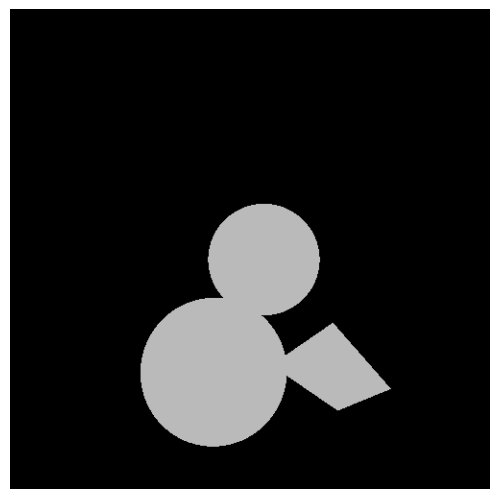

True

In [8]:

#  Only check if ray intersects the objects or not, does not computer color
def vanilla_ray_cast(ray, objects):
    inter = ray.intersect_scene(objects)
    if inter is None:
        color = Vec3(0, 0, 0)
    else:
        color = Vec3(1, 1, 1)*0.5
    return color

# initialize scene with three spheres
scene = []  # scene stores a list of objects
scene.append(Sphere(Vec3(12, 9, 600), 50))
scene.append(Sphere(Vec3(-30, 100, 550), 60))

vertices = [
    # Vec3(113, 95, 686),  # Vertex 0
    # Vec3(41, 59, 667),   # Vertex 1
    Vec3(85, 157, 649),  # Vertex 2
    # Vec3(120, 43, 630),  # Vertex 3
    Vec3(19, 106, 611),  # Vertex 4
    Vec3(125, 124, 593), # Vertex 5
    Vec3(71, 63, 574)    # Vertex 6
]
scene.append(Tetrahedron(vertices))
# scene.append(Sphere(Vec3(80, 95, 630), 65))

# camera captured image
img = np.zeros((cam_h, cam_w, 3))

# render using ray casting
print('Ray casting...')
for x in range(cam_w):  # for each col
    if fmod(x, cam_w // 10) == 0:  # print ray casting progress
        print('{:.2f}%'.format(x / cam_w * 100))
    for y in range(cam_h):  # for each row

        ##########--WRITE YOUR CODE HERE--##########]

        ray_dir = cam_ray_dir(inv_cam_k, cam_pos, focal_length, x, y)
        ray = Ray(cam_pos, ray_dir)

        ##########-------END OF CODE-------##########

        color = vanilla_ray_cast(ray, scene)
        img[y, x] = color

# apply gamma correction (1/2.2) for display
img = np.power(img, 1 / 2.2)
imshow(img)
cv.imwrite('Results/vanilla_ray_cast.png', img[..., ::-1] * 255)



Ray casting...
0.00%
10.00%
20.00%
30.00%
40.00%
50.00%
60.00%
70.00%
80.00%
90.00%


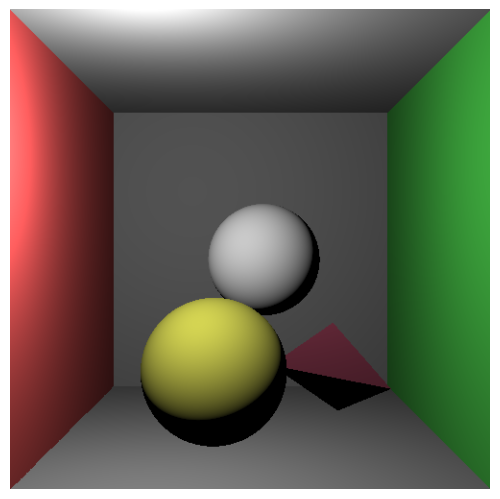

True

In [9]:
# Light source (point light)
class Light(object):
    def __init__(self, position, power, ambient, diffuse, specular):
        self.p = position  # position, Vec3
        self.power = power  # light intensity/brightness
        self.ambient = ambient
        self.diffuse = diffuse
        self.specular = specular

# Phong diffuse (lambertian) color
def diffuseColor(inter, light):
    color = 0

    ##########--WRITE YOUR CODE HERE--##########
   # Calculate the direction from the intersection point to the light source
    to_light = light.p - inter.p
    to_light /= np.linalg.norm(to_light)  # Normalize the direction vector

    # Calculate the diffuse color using Lambert's law
    if hasattr(inter.obj, 'mat') and 'kd' in inter.obj.mat:
        color = inter.obj.mat['kd'] * max(0, np.dot(inter.n, to_light)) * light.power
    ##########-------END OF CODE-------##########

    return color


def lambertian_ray_cast(ray, objects, light):
    inter = ray.intersect_scene(objects)
    if inter is None:
        color = Vec3(0, 0, 0)
    else:

        # Create a shadow ray from the intersection point to the light source
        ##########--WRITE YOUR CODE HERE--##########

        to_light = light.p - inter.p  # Vector from intersection point to light source
        distance_to_light = np.linalg.norm(to_light)  # Distance to light source
        shadow_ray = Ray(inter.p, to_light / distance_to_light)  # Ray from intersection point to light source

        # Check if there is any occlusion between the intersection point and the light source
        shadow_inter = shadow_ray.intersect_scene(objects, ignored_obj=inter.obj)

        # If there is no occlusion, calculate diffuse lighting
        if shadow_inter is None:
            color = diffuseColor(inter.obj, inter, light)
        else:
            color = Vec3(0, 0, 0)  # Shadow

        ##########-------END OF CODE-------##########

        # If not in shadow, calculate diffuse lighting as before
        d = distance_to_light
        color = np.clip(diffuseColor(inter, light) / (4 * np.pi * d * d), 0, 1)
    return color


# Render
# Phong illumination materials
plaster_white = {'ka': Vec3(0.03), 'kd': Vec3(0.5), 'ks': Vec3(0.1), 'shine': 5}
plaster_red = {'ka': Vec3(0.9, 0.1, 0.1) * 0.01, 'kd': Vec3(0.9, 0.1, 0.1), 'ks': Vec3(0.1), 'shine': 5}
plaster_green = {'ka': Vec3(0.1, 0.9, 0.1) * 0.01, 'kd': Vec3(0.1, 0.9, 0.1), 'ks': Vec3(0.1), 'shine': 5}
marble_white = {'ka': Vec3(0.01), 'kd': Vec3(0.8), 'ks': Vec3(1.0), 'shine': 200.0}
marble_yellow = {'ka': Vec3(0.8, 0.8, 0.1) * 0.1, 'kd': Vec3(0.8, 0.8, 0.1), 'ks': Vec3(1.0), 'shine': 200.0}
plastic_red = {'ka': Vec3(0.7, 0.1, 0.2) * 0.01, 'kd': Vec3(0.7, 0.1, 0.2), 'ks': Vec3(0.2), 'shine': 20}

# initialize scene with spheres and a box
scene = []  # scene stores a list of objects
# a box
scene.append(Plane(Vec3(0, -160, 0), Vec3(0, 1, 0), plaster_white))  # ceiling
scene.append(Plane(Vec3(0, 160, 0), Vec3(0, -1, 0), plaster_white))  # floor
scene.append(Plane(Vec3(-160, 0, 0), Vec3(1, 0, 0), plaster_red))  # left
scene.append(Plane(Vec3(160, 0, 0), Vec3(-1, 0, 0), plaster_green))  # right
scene.append(Plane(Vec3(0, 0, 780), Vec3(0, 0, -1), plaster_white))  # back
# spheres
scene.append(Sphere(Vec3(12, 9, 600), 50, marble_white))
scene.append(Sphere(Vec3(-30, 100, 550), 60, marble_yellow))

vertices = [
    # Vec3(113, 95, 686),  # Vertex 0
    # Vec3(41, 59, 667),   # Vertex 1
    Vec3(85, 157, 649),  # Vertex 2
    # Vec3(120, 43, 630),  # Vertex 3
    Vec3(19, 106, 611),  # Vertex 4
    Vec3(125, 124, 593), # Vertex 5
    Vec3(71, 63, 574)    # Vertex 6
]
scene.append(Tetrahedron(vertices,plastic_red))
# scene.append(Sphere(Vec3(80, 95, 630), 65, plastic_red))

# initialize a point light
light = Light(Vec3(-68, -68, 400), 300000, Vec3(1.0), Vec3(1.0), Vec3(1.0))

# camera captured image
img = np.zeros((cam_h, cam_w, 3))

# render using ray casting
print('Ray casting...')
for x in range(cam_w):  # for each col
    if fmod(x, cam_w // 10) == 0:  # print ray casting progress
        print('{:.2f}%'.format(x / cam_w * 100))
    for y in range(cam_h):  # for each row

        ##########--WRITE YOUR CODE HERE--##########
        ray_dir = cam_ray_dir(inv_cam_k, cam_pos, focal_length, x, y)
        ray = Ray(cam_pos, ray_dir)  # shoot a ray through (x, y)
        ##########-------END OF CODE-------##########

        color = lambertian_ray_cast(ray, scene, light)
        img[y, x] = color

# apply gamma correction (1/2.2) for display
img = np.power(img, 1 / 2.2)
imshow(img)
cv.imwrite('Results/lambertian_ray_cast.png', img[..., ::-1] * 255)



In [29]:
#1.   Is the above image photorealistic enough? How can we improve it?
  #*  Add more lights, materials and objects.
  #*  Add textures.
  #*  Acceleration techniques, e.g., depth clipping, bounding box, BVH, k-d tree, multithreading, GPU.
  #*  Depth of field.
  #*  Add transparency, inter-reflection, volume scattering, caustics, etc.

# Load the rendered image
#rendered_image = cv2.imread('Results/lambertian_ray_cast.png')

# 1. Estimate Lighting Direction and Color
# TODO: Implement lighting direction and color estimation algorithms

# 2. Estimate Object Surface Normals
# TODO: Implement surface normal estimation techniques

# 3. Estimate Material Properties
# TODO: Implement material property estimation algorithms

# 4. Estimate Camera Parameters
# TODO: Implement camera calibration and pose estimation algorithms

# Display the rendered image with estimated parameters
#cv2.imshow('Rendered Image with Estimated Parameters', rendered_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


#One solution may be Specular reflection in this case
#Implementation of Specular Reflection

# Specular reflection color
def specularColor(inter, light):
    color = 0

    ##########--WRITE YOUR CODE HERE--##########
    # Calculate the direction from the intersection point to the light source
    to_light = light.p - inter.p
    to_light /= np.linalg.norm(to_light)  # Normalize the direction vector

    # Calculate the direction of reflection
    reflection_dir = np.reflect(-to_light, inter.n)

    # Calculate the specular color using Phong reflection model
    if hasattr(inter.obj, 'mat') and 'ks' in inter.obj.mat and 'shine' in inter.obj.mat:
        specular_coeff = max(0, np.dot(reflection_dir, -ray.d)) ** inter.obj.mat['shine']
        color = inter.obj.mat['ks'] * specular_coeff * light.power
    ##########-------END OF CODE-------##########

    return color


def phong_ray_cast(ray, objects, light):
    inter = ray.intersect_scene(objects)
    if inter is None:
        color = Vec3(0, 0, 0)
    else:

        # Create a shadow ray from the intersection point to the light source
        to_light = light.p - inter.p  # Vector from intersection point to light source
        distance_to_light = np.linalg.norm(to_light)  # Distance to light source
        shadow_ray = Ray(inter.p, to_light / distance_to_light)  # Ray from intersection point to light source

        # Check if there is any occlusion between the intersection point and the light source
        shadow_inter = shadow_ray.intersect_scene(objects, ignored_obj=inter.obj)

        # If there is no occlusion, calculate diffuse and specular lighting
        if shadow_inter is None:
            diffuse = diffuseColor(inter, light)
            specular = specularColor(inter, light)
            color = diffuse + specular
        else:
            color = Vec3(0, 0, 0)  # Shadow

    return color


# Render with Phong shading (diffuse + specular)
# initialize a point light
light = Light(Vec3(-68, -68, 400), 300000, Vec3(1.0), Vec3(1.0), Vec3(1.0))

# camera captured image
img = np.zeros((cam_h, cam_w, 3))

# render using ray casting with Phong shading
print('Ray casting with Phong shading...')
for x in range(cam_w):  # for each col
    if fmod(x, cam_w // 10) == 0:  # print ray casting progress
        print('{:.2f}%'.format(x / cam_w * 100))
    for y in range(cam_h):  # for each row

        # shoot a ray through (x, y)
        ray_dir = cam_ray_dir(inv_cam_k, cam_pos, focal_length, x, y)
        ray = Ray(cam_pos, ray_dir)

        # apply Phong shading (diffuse + specular)
        color = phong_ray_cast(ray, scene, light)
        img[y, x] = color

# apply gamma correction (1/2.2) for display
img = np.power(img, 1 / 2.2)
imshow(img)
cv.imwrite('Results/phong_ray_cast.png', img[..., ::-1] * 255)


Ray casting with Phong shading...
0.00%


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:

2.   How do human visual systems tell whether an image is real or fake? Apparently, shadows are an important cue.

     Indeed, shadows are a major factor in influencing how realistic an image appears to the human eye. Our minds are
     skilled at deciphering the small clues that shadows and lighting in a scene convey. The following are some ways
     that shadows enhance the sense of realism:

     --Depth Perception: We may discern the spatial relationships between things in a scene by using the depth signals
     that shadows give. Clues regarding the relative positions of objects and their distance from light sources can be
     found in the presence, size, and direction of shadows.

     --Surface Detail: By highlighting changes in elevation and curvature, shadows highlight surface details and texture.
     This enhances our ability to detect items' three-dimensional structure, giving them a more palpable and realistic
     appearance.

     --Lighting Consistency: The scene's lighting is consistent with the realistic shadows. A feeling of artificiality
     might result from items appearing out of place or with missing or inaccurate shadows.

     --Temporal Changes: The perception of a dynamic and changing scene is influenced by the way shadows shift over time,
     particularly when objects or light sources move. If there are no such adjustments, the scene may appear lifeless
     and artificial.

    --Emotional Impact: By altering a scene's tone and ambiance, shadows have the power to arouse feelings in viewers.
    They can produce enigmatic or dramatic effects that deepen the narrative and increase audience interest.

    In conclusion, the existence, consistency, and quality of shadows are crucial indicators of an image's reality.
    Whether in computer graphics, photography, or other visual media, their precise representation is essential to
    producing visually compelling and engaging virtual worlds.


3.   Inverse problem: can we estimate lighting (direction and color), object surface normal, material and camera parameters from the image above?

     Although it's a difficult problem, academics have created a number of methods and algorithms to solve it.
     Here's a quick rundown of the estimation methods for each parameter:

     --Lighting Direction and Color: Examining the image's shading and shadows will help you estimate the direction and
      color of the light sources.

     --Surface Normal: Surface normals can be determined by techniques such as photometric stereo, which infers surface
      orientation by analyzing shade variations over the object's surface.

     --Material attributes: Examining how surfaces appear in various lighting scenarios is necessary to estimate
     attributes of materials like reflectance and specular highlights. Material parameters can be inferred and
     observable surface reflectance properties can be fitted using reflectance models like the Phong or
     Lambertian models.

    --Camera Parameters: Camera calibration techniques can be used to determine camera parameters such as focus length,
     distortion, and location.

    Although it is possible to estimate any of these factors separately, it is a difficult undertaking to integrate
    them into a cohesive framework for scene analysis.

































